Run WIT for  ReedyLake for David Crook

In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import os
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
import seaborn as sns
from shapely import geometry
import sys
import xarray as xr

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from textwrap import wrap

from datacube.storage import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from digitalearthau.utils import wofs_fuser

sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, WetlandsTools, SpatialTools, wetlands_insight

dc = datacube.Datacube(app='wetlands insight tool')
%load_ext autoreload
%autoreload 2

In [2]:
#set output directory
global Output_dir
Output_dir = '/g/data/r78/rjd547/Melbourne_water/'

In [3]:
#set polygon path
poly_path='/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/updated_ramsar/ramsar_wetlands/reedylakeramsar.shp'

In [4]:
polyname='ReedyLakeSplit'

In [5]:
with fiona.open(poly_path) as shapes:
    #get crs object from polygon file
    crs = geometry.CRS(shapes.crs_wkt)
    for feature in shapes:
    
        if feature['id'] == str(0): 
            feature_geometry=feature['geometry']            
            geom = geometry.Geometry(feature_geometry, crs=crs)
            query = {'geopolygon': geom}
            print(query)
            #if os.path.exists(f'{Output_dir}{polyName}.csv')==False or os.path.exists(f'{Output_dir}{polyName}.png')==False:

{'geopolygon': Geometry(POLYGON ((16077485.4696202 -4610601.73823474,16076502.370061 -4610689.5149811,16076258.3474956 -4610324.53782302,16076050.9417115 -4610108.10125397,16075921.0763314 -4609828.04868505,16075789.8918746 -4609831.09130745,16075596.5132936 -4609920.36010009,16075237.6692793 -4609948.40770895,16075104.3781642 -4609870.16995329,16075017.5897073 -4609858.63447769,16075126.1484353 -4609096.40198068,16075130.0623168 -4609068.91626938,16075140.9911513 -4608992.17751646,16075269.4389444 -4609011.32912057,16075593.3637678 -4608540.04400426,16075213.1038791 -4608485.79938985,16075249.664908 -4608229.0587966,16075285.6090463 -4607976.6366747,16075321.1523359 -4607723.13942476,16075356.7338683 -4607469.3534993,16075611.1470756 -4607506.39859264,16076370.6410045 -4607616.92930894,16076501.9971535 -4606728.08660407,16076961.48033 -4606688.72255886,16077500.9337307 -4606642.47866902,16077522.3728311 -4606649.04709472,16077948.7562535 -4606779.68379368,16078437.7780977 -4606929.487

## run WIT over each polygon, along with the fast version of the csv writer. 

In [11]:
#set up colour palette for our plots
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]  

In [12]:
with fiona.open(poly_path) as shapes:
    #get crs object from polygon file
    crs = geometry.CRS(shapes.crs_wkt)
    for feature in shapes:
        #name our polygon using the get MER polyname function    
        feature_geometry=feature['geometry']           
        geom = geometry.Geometry(feature_geometry, crs=crs)
        query = {'geopolygon': geom}
        
        #if this polyon has already been run, don't run it again!
        if os.path.exists(f'{Output_dir}{polyname}.csv')==False or os.path.exists(f'{Output_dir}{polyname}.png')==False:
            #get our data
            WITplots=wetlands_insight.WIT_array(query)
            #make a stacked area plot
            plt.clf()
            fig= plt.figure(figsize = (12,4))
            plt.stackplot(WITplots.water.time.values, 
                          WITplots.water, 
                          WITplots.wet, 
                          WITplots.green, 
                          WITplots.dry,
                          WITplots.bare,
                          labels=['water',
                                  'wet',
                                  'green veg',
                                  'dry veg',
                                  'bare soil',
                                 ], colors=pal, alpha = 0.6)


            #set axis limits to the min and max
            plt.axis(xmin = WITplots.water.time[0].data, xmax = WITplots.water.time[-1].data, ymin = 0, ymax = 100)

            #add a legend and a tight plot box
            plt.legend(loc='lower left', framealpha=0.6)
            #plt.tight_layout()

            #create rectangle borders for no-data times (SLC-off only)
            LS5_8_gap_start = datetime(2011,11,1)
            LS5_8_gap_end = datetime(2013,4,1)

            # convert to matplotlib date representation
            gap_start = mdates.date2num(LS5_8_gap_start)
            gap_end = mdates.date2num(LS5_8_gap_end)
            gap = gap_end - gap_start


            #set date ticks every year
            years = mdates.YearLocator(2)
            yearsFmt = mdates.DateFormatter('%Y')
            ax = plt.gca()
            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(yearsFmt)
            #ax.yaxis.set_ticks(np.arange(0,110,10))
            ax.set_xlabel(f'The Fractional Cover algorithm developed by the Joint Remote'
            f' Sensing Research Program and \n the Water Observations from Space algorithm '
            f'developed by Geoscience Australia are used in the production of this data',style='italic')


            #set up rectangle
            slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
                         edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
            ax.add_patch(slc_rectangle)
            fig.autofmt_xdate()


            polyname=polyname.replace("'","\\'")
            title=ax.set_title("\n".join(wrap(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyname}')))
            fig.tight_layout()
            title.set_y(1.05)

            #save the figure
            plt.savefig(f'{Output_dir}{polyname}.png')#, transparent=True)
            plt.show()
            print(f'plot created for {polyname}')

            #save a csv for the polygon
            WITcsvs= WITplots.to_dataframe().round(2) #turn the xarray into a pandas dataframe and then into a csv!
            WITcsvs.to_csv(f'{Output_dir}{polyname}.csv')
            print(f'wrote output data to file {Output_dir}{polyname}.csv')            

Loading ls5
    Loading 105 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 21 filtered ls7 timesteps
Loading ls8
    Loading 46 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float32)
Loading ls5
    Loading 105 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 21 filtered ls7 timesteps
Loading ls8
    Loading 46 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float32)


<Figure size 432x288 with 0 Axes>

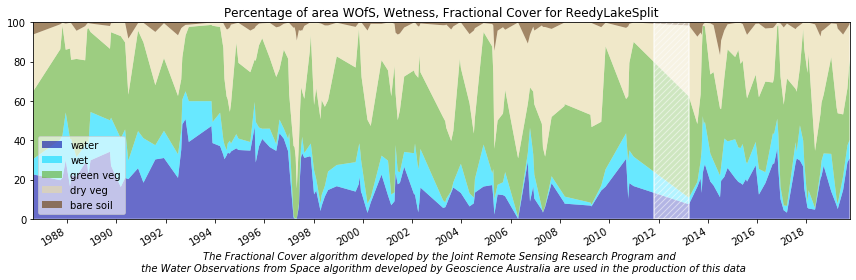

plot created for ReedyLakeSplit
wrote output data to file /g/data/r78/rjd547/Melbourne_water/ReedyLakeSplit.csv


In [15]:
WITplots=wetlands_insight.WIT_array(query)
            #make a stacked area plot
plt.clf()
fig= plt.figure(figsize = (12,4))
plt.stackplot(WITplots.water.time.values, 
              WITplots.water, 
              WITplots.wet, 
              WITplots.green, 
              WITplots.dry,
              WITplots.bare,
              labels=['water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)


#set axis limits to the min and max
plt.axis(xmin = WITplots.water.time[0].data, xmax = WITplots.water.time[-1].data, ymin = 0, ymax = 100)

#add a legend and a tight plot box
plt.legend(loc='lower left', framealpha=0.6)
#plt.tight_layout()

#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime(2011,11,1)
LS5_8_gap_end = datetime(2013,4,1)

# convert to matplotlib date representation
gap_start = mdates.date2num(LS5_8_gap_start)
gap_end = mdates.date2num(LS5_8_gap_end)
gap = gap_end - gap_start


#set date ticks every year
years = mdates.YearLocator(2)
yearsFmt = mdates.DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
#ax.yaxis.set_ticks(np.arange(0,110,10))
ax.set_xlabel(f'The Fractional Cover algorithm developed by the Joint Remote'
f' Sensing Research Program and \n the Water Observations from Space algorithm '
f'developed by Geoscience Australia are used in the production of this data',style='italic')


#set up rectangle
slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
             edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
ax.add_patch(slc_rectangle)
fig.autofmt_xdate()


polyname=polyname.replace("'","\\'")
title=ax.set_title("\n".join(wrap(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyname}')))
fig.tight_layout()
title.set_y(1.05)

#save the figure
plt.savefig(f'{Output_dir}{polyname}.png')#, transparent=True)
plt.show()
print(f'plot created for {polyname}')

#save a csv for the polygon
WITcsvs= WITplots.to_dataframe().round(2) #turn the xarray into a pandas dataframe and then into a csv!
WITcsvs.to_csv(f'{Output_dir}{polyname}.csv')
print(f'wrote output data to file {Output_dir}{polyname}.csv')            